In [1]:
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, LSTM, RepeatVector
from keras.models import Model
from keras.models import model_from_json
from keras import regularizers
import datetime
import time
import requests as req
import json
import pandas as pd
import pickle
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Parameters

In [2]:
startdate="01/01/2015"
window_length = 10
encoding_dim = 3
epochs = 100
test_samples = 2000

## Utils

In [3]:
def mkdate(ts):
    return datetime.datetime.fromtimestamp(
        int(ts)
    ).strftime('%Y-%m-%d')

def plot_examples(stock_input, stock_decoded):
    n = 10  
    plt.figure(figsize=(20, 4))
    for i, idx in enumerate(list(np.arange(0, test_samples, 200))):
        # display original
        ax = plt.subplot(2, n, i + 1)
        if i == 0:
            ax.set_ylabel("Input", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_input[idx])
        ax.get_xaxis().set_visible(False)
        

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        if i == 0:
            ax.set_ylabel("Output", fontweight=600)
        else:
            ax.get_yaxis().set_visible(False)
        plt.plot(stock_decoded[idx])
        ax.get_xaxis().set_visible(False)
        
        
def plot_history(history):
    plt.figure(figsize=(15, 5))
    ax = plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.title("Train loss")
    ax = plt.subplot(1, 2, 2)
    plt.plot(history.history["val_loss"])
    plt.title("Test loss")

## Datasets retrieval & transformation

In [4]:
# get data
start_timestamp = time.mktime(datetime.datetime.strptime(startdate, "%d/%m/%Y").timetuple())
end_timestamp = int(time.time())
one_week = 3600*24*7 # s
one_day = 3600*24 # s
weeks = list(np.arange(start_timestamp, end_timestamp, one_week))
days_recorded = (datetime.datetime.fromtimestamp(end_timestamp)-datetime.datetime.fromtimestamp(start_timestamp)).days
print("days_recorded ",days_recorded)
data = []
if not os.path.isfile("data.pickle"):
    s = req.Session()
    r = s.get("https://www.coindesk.com/price/")
    for i in range(1, len(weeks)):
        start_weekday = mkdate(weeks[i-1])
        end_weekday = mkdate(weeks[i]-one_day)
        print(start_weekday, end_weekday)
        r = s.get("https://api.coindesk.com/charts/data?data=close&startdate={}&enddate={}&exchanges=bpi&dev=1&index=USD".format(start_weekday, end_weekday))
        ans = json.loads(r.text.replace("cb(", "").replace(");",""))["bpi"]
        ans.sort(key=lambda x: x[0])
        for pricepoint in ans:
            if pricepoint[0]/1000 >= weeks[i-1] and pricepoint[0]/1000 < (weeks[i]-one_day):
                data.append([int(pricepoint[0]/1000), pricepoint[1]])
                
    pickle.dump(data, open("./data.pickle", "wb"))
else:
    data = pickle.load(open("./data.pickle", "rb"))

df = pd.DataFrame(np.array(data)[:,1], columns=['price'])
df['pct_change'] = df.price.pct_change()
df['log_ret'] = np.log(df.price) - np.log(df.price.shift(1))

scaler = MinMaxScaler()
x_train_nonscaled = np.array([df['log_ret'].values[i-window_length:i].reshape(-1, 1) for i in tqdm(range(window_length+1,len(df['log_ret'])))])
x_train = np.array([scaler.fit_transform(df['log_ret'].values[i-window_length:i].reshape(-1, 1)) for i in tqdm(range(window_length+1,len(df['log_ret'])))])

x_test = x_train[-test_samples:]
x_train = x_train[:-test_samples]

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

days_recorded  2363
2015-01-01 2015-01-07
2015-01-08 2015-01-14
2015-01-15 2015-01-21
2015-01-22 2015-01-28
2015-01-29 2015-02-04
2015-02-05 2015-02-11
2015-02-12 2015-02-18
2015-02-19 2015-02-25
2015-02-26 2015-03-04
2015-03-05 2015-03-11
2015-03-12 2015-03-18
2015-03-19 2015-03-25
2015-03-26 2015-04-01
2015-04-02 2015-04-08
2015-04-09 2015-04-15
2015-04-16 2015-04-22
2015-04-23 2015-04-29
2015-04-30 2015-05-06
2015-05-07 2015-05-13
2015-05-14 2015-05-20
2015-05-21 2015-05-27
2015-05-28 2015-06-03
2015-06-04 2015-06-10
2015-06-11 2015-06-17
2015-06-18 2015-06-24
2015-06-25 2015-07-01
2015-07-02 2015-07-08
2015-07-09 2015-07-15
2015-07-16 2015-07-22
2015-07-23 2015-07-29
2015-07-30 2015-08-05
2015-08-06 2015-08-12
2015-08-13 2015-08-19
2015-08-20 2015-08-26
2015-08-27 2015-09-02
2015-09-03 2015-09-09
2015-09-10 2015-09-16
2015-09-17 2015-09-23
2015-09-24 2015-09-30
2015-10-01 2015-10-07
2015-10-08 2015-10-14
2015-10-15 2015-10-21
2015-10-22 2015-10-28
2015-10-29 2015-11-04
2015-11-05 2

100%|██████████| 43983/43983 [00:06<00:00, 6707.42it/s]


In [29]:
data

[[1420070400, 318.19],
 [1420074000, 316.9],
 [1420077600, 316.91],
 [1420081200, 317.27],
 [1420084800, 314.05],
 [1420088400, 314.52],
 [1420092000, 314.9],
 [1420095600, 314.93],
 [1420099200, 315.11],
 [1420102800, 315.44],
 [1420106400, 315.07],
 [1420110000, 314.91],
 [1420113600, 315.19],
 [1420117200, 315.32],
 [1420120800, 315.06],
 [1420124400, 314.98],
 [1420128000, 315.03],
 [1420131600, 314.82],
 [1420135200, 314.79],
 [1420138800, 314.66],
 [1420142400, 314.83],
 [1420146000, 314.27],
 [1420149600, 314.76],
 [1420153200, 313.92],
 [1420156800, 312.83],
 [1420160400, 314.5],
 [1420164000, 314.37],
 [1420167600, 314.58],
 [1420171200, 314.51],
 [1420174800, 314.67],
 [1420178400, 314.34],
 [1420182000, 313.34],
 [1420185600, 314.05],
 [1420189200, 313.95],
 [1420192800, 314.13],
 [1420196400, 314.22],
 [1420200000, 314.57],
 [1420203600, 314.34],
 [1420207200, 314.94],
 [1420210800, 314.73],
 [1420214400, 313.96],
 [1420218000, 314.16],
 [1420221600, 314.81],
 [1420225200, 

In [25]:
df

,price,pct_change,log_ret
0,318.19,NaN,NaN
1,316.90,-0.004054,-0.004062
2,316.91,0.000032,0.000032
3,317.27,0.001136,0.001135
4,314.05,-0.010149,-0.010201
...,...,...,...
43989,40020.86,-0.008132,-0.008165
43990,40060.68,0.000995,0.000994
43991,40237.24,0.004407,0.004398
43992,40683.47,0.011090,0.011029


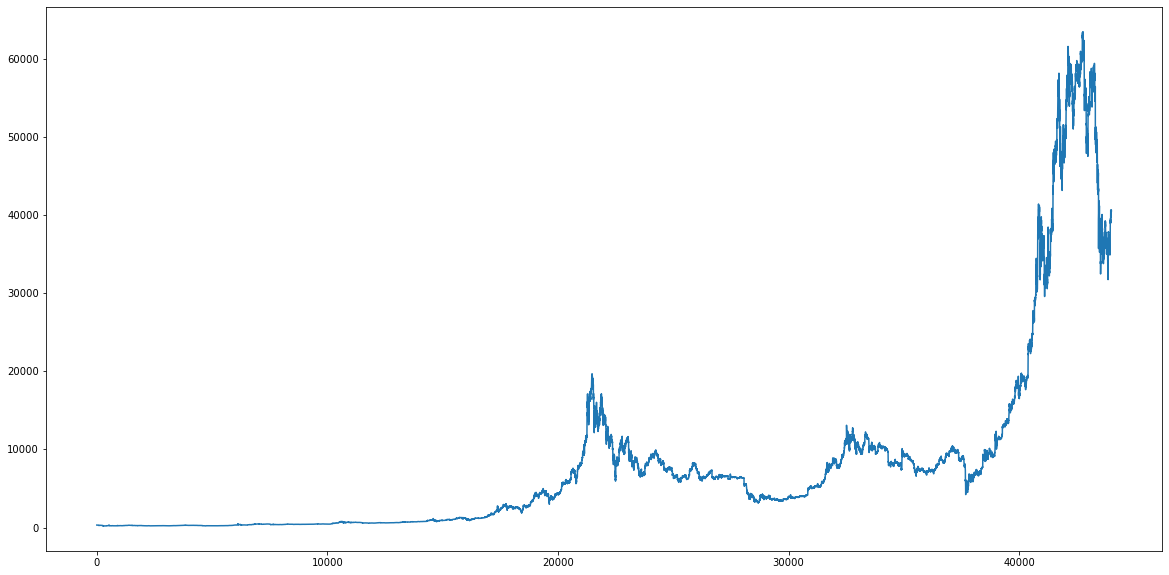

In [5]:
plt.figure(figsize=(20,10))
plt.plot(np.array(data)[:,1])

In [6]:
print("Percentage of test data: {}%".format((test_samples/len(x_train))*100))

Percentage of test data: 4.763832980015721%


## Simple feed-forward autoencoder

In [7]:
x_train_simple = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# this is our input placeholder
input_window = Input(shape=(window_length,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_window)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(window_length, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense (Dense)                (None, 3)                 33        
_________________________________________________________________
dense_1 (Dense)              (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
41/41 [==============================] - 10s 10ms/step - loss: 0.7237 - val_loss: 0.7087
Epoch 2/100
41/41 [==============================] - 0s 2ms/step - loss: 0.7053 - val_loss: 0.6976
Epoch 3/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6956 - val_loss: 0.6921
Epoch 4/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6906 - val_loss: 0.68

41/41 [==============================] - 0s 2ms/step - loss: 0.6136 - val_loss: 0.6178
Epoch 76/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6135 - val_loss: 0.6177
Epoch 77/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6139 - val_loss: 0.6177
Epoch 78/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6139 - val_loss: 0.6177
Epoch 79/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6134 - val_loss: 0.6176
Epoch 80/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6139 - val_loss: 0.6176
Epoch 81/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6135 - val_loss: 0.6175
Epoch 82/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6136 - val_loss: 0.6175
Epoch 83/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6135 - val_loss: 0.6175
Epoch 84/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6136 - val_loss: 0.6175
Epoch 85/100


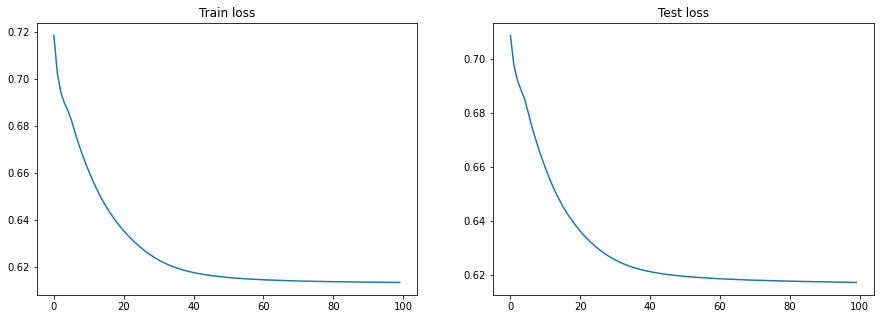

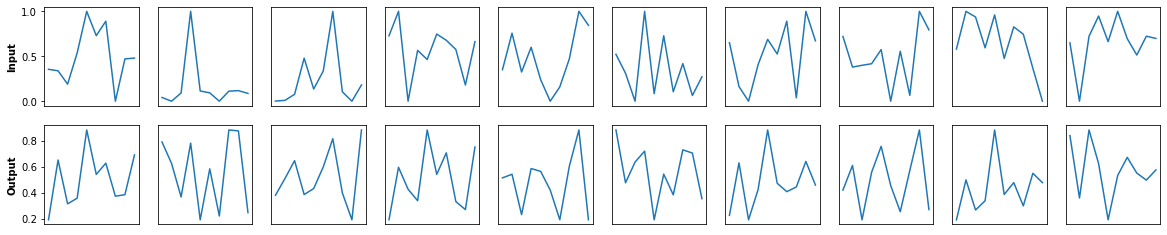

In [8]:
plot_history(history)
plot_examples(x_test_simple, decoded_stocks)

## Deep autoencoder

In [9]:
x_train_deep = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
# "decoded" is the lossy reconstruction of the input

x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)

# this model maps an input to its reconstruction
autoencoder = Model(input_window, decoded)

# this model maps an input to its encoded representation
encoder = Model(input_window, encoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 66        
_________________________________________________________________
batch_normalization (BatchNo (None, 6)                 24        
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 24        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
dense_5 (Dense)              (None, 10)                70  

41/41 [==============================] - 0s 2ms/step - loss: 0.6112 - val_loss: 0.6134
Epoch 71/100
41/41 [==============================] - 0s 2ms/step - loss: 0.6110 - val_loss: 0.6134
Epoch 72/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6113 - val_loss: 0.6134
Epoch 73/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6110 - val_loss: 0.6134
Epoch 74/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6113 - val_loss: 0.6134
Epoch 75/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6113 - val_loss: 0.6134
Epoch 76/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6114 - val_loss: 0.6134
Epoch 77/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6117 - val_loss: 0.6134
Epoch 78/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6113 - val_loss: 0.6134
Epoch 79/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6113 - val_loss: 0.6134
Epoch 80/100


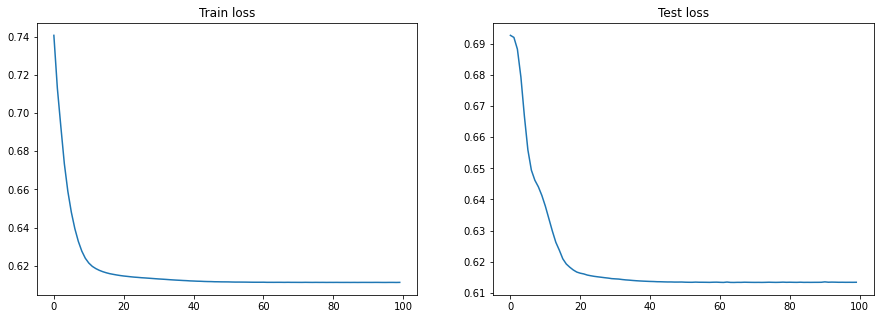

In [10]:
plot_history(history)

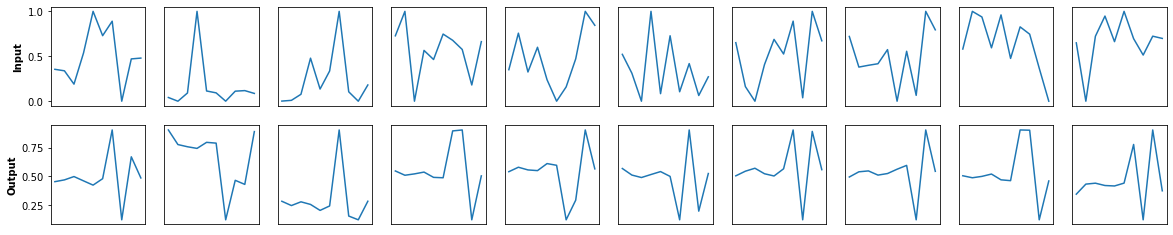

In [11]:
plot_examples(x_test_deep, decoded_stocks)

## 1D Convolutional autoencoder

In [12]:
input_window = Input(shape=(window_length,1))
x = Conv1D(16, 3, activation="relu", padding="same")(input_window) # 10 dims
#x = BatchNormalization()(x)
x = MaxPooling1D(2, padding="same")(x) # 5 dims
x = Conv1D(1, 3, activation="relu", padding="same")(x) # 5 dims
#x = BatchNormalization()(x)
encoded = MaxPooling1D(2, padding="same")(x) # 3 dims

encoder = Model(input_window, encoded)

# 3 dimensions in the encoded layer

x = Conv1D(1, 3, activation="relu", padding="same")(encoded) # 3 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 6 dims
x = Conv1D(16, 2, activation='relu')(x) # 5 dims
#x = BatchNormalization()(x)
x = UpSampling1D(2)(x) # 10 dims
decoded = Conv1D(1, 3, activation='sigmoid', padding='same')(x) # 10 dims
autoencoder = Model(input_window, decoded)
autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = autoencoder.predict(x_test)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 10, 16)            64        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 5, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 1)              49        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 1)              0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 1)              4         
_________________________________________________________________
up_sampling1d (UpSampling1D) (None, 6, 1)              0   

41/41 [==============================] - 1s 21ms/step - loss: 0.6186 - val_loss: 0.6210
Epoch 66/100
41/41 [==============================] - 1s 19ms/step - loss: 0.6195 - val_loss: 0.6210
Epoch 67/100
41/41 [==============================] - 1s 20ms/step - loss: 0.6197 - val_loss: 0.6209
Epoch 68/100
41/41 [==============================] - 1s 22ms/step - loss: 0.6191 - val_loss: 0.6209
Epoch 69/100
41/41 [==============================] - 1s 26ms/step - loss: 0.6193 - val_loss: 0.6209
Epoch 70/100
41/41 [==============================] - 1s 28ms/step - loss: 0.6197 - val_loss: 0.6209
Epoch 71/100
41/41 [==============================] - 1s 26ms/step - loss: 0.6199 - val_loss: 0.6209
Epoch 72/100
41/41 [==============================] - 1s 26ms/step - loss: 0.6195 - val_loss: 0.6209
Epoch 73/100
41/41 [==============================] - 1s 28ms/step - loss: 0.6194 - val_loss: 0.6209
Epoch 74/100
41/41 [==============================] - 1s 27ms/step - loss: 0.6195 - val_loss: 0.6209
Epo

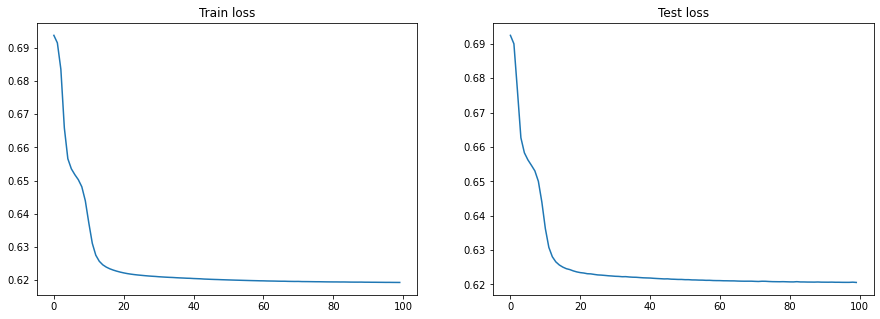

In [13]:
plot_history(history)

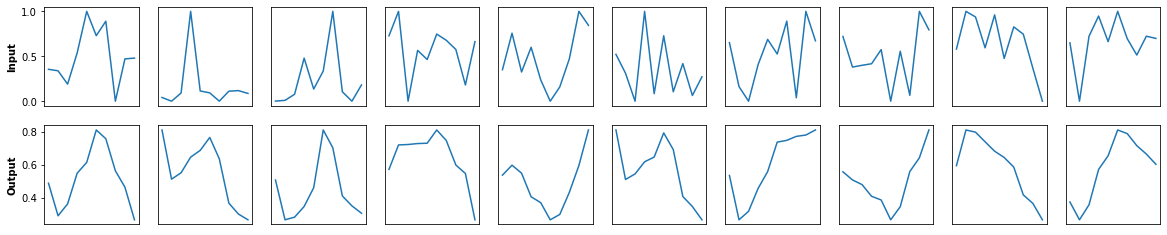

In [14]:
plot_examples(x_test_deep, decoded_stocks)

## LSTM (recurrent neural networks) autoencoder

In [15]:
inputs = Input(shape=(window_length, 1))
encoded = LSTM(encoding_dim)(inputs)

decoded = RepeatVector(window_length)(encoded)
decoded = LSTM(1, return_sequences=True)(decoded)

sequence_autoencoder = Model(inputs, decoded)
encoder = Model(inputs, encoded)
sequence_autoencoder.summary()

sequence_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = sequence_autoencoder.fit(x_train, x_train,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test, x_test))

decoded_stocks = sequence_autoencoder.predict(x_test)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 10, 1)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 3)                 60        
_________________________________________________________________
repeat_vector (RepeatVector) (None, 10, 3)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 1)             20        
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
41/41 [==============================] - 19s 57ms/step - loss: 1.1159 - val_loss: 0.9551
Epoch 2/100
41/41 [==============================] - 1s 23ms/step - loss: 0.9222 - val_loss: 0.8311
Epoch 3/100
41/41 [==============================] - 1s 21ms

41/41 [==============================] - 1s 27ms/step - loss: 0.6571 - val_loss: 0.6614
Epoch 74/100
41/41 [==============================] - 1s 24ms/step - loss: 0.6575 - val_loss: 0.6614
Epoch 75/100
41/41 [==============================] - 1s 24ms/step - loss: 0.6569 - val_loss: 0.6613
Epoch 76/100
41/41 [==============================] - 1s 25ms/step - loss: 0.6573 - val_loss: 0.6613
Epoch 77/100
41/41 [==============================] - 1s 32ms/step - loss: 0.6574 - val_loss: 0.6613
Epoch 78/100
41/41 [==============================] - 1s 30ms/step - loss: 0.6575 - val_loss: 0.6612
Epoch 79/100
41/41 [==============================] - 1s 28ms/step - loss: 0.6570 - val_loss: 0.6612
Epoch 80/100
41/41 [==============================] - 1s 27ms/step - loss: 0.6572 - val_loss: 0.6612
Epoch 81/100
41/41 [==============================] - 1s 24ms/step - loss: 0.6569 - val_loss: 0.6611
Epoch 82/100
41/41 [==============================] - 1s 25ms/step - loss: 0.6572 - val_loss: 0.6611
Epo

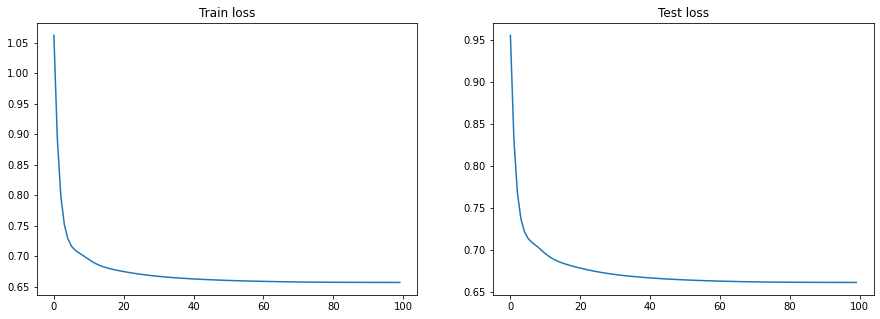

In [16]:
plot_history(history)

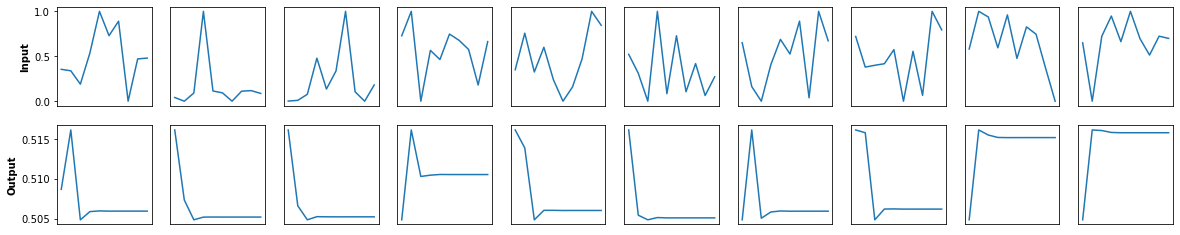

In [17]:
plot_examples(x_test, decoded_stocks)

## Simple AE + augmention with synthetic data

In [18]:
synthesized = []
required_nums = [0, 1]
optional_nums = list(np.arange(0.1, 0.9, 0.1))
for i in tqdm(range(100000)):
    combo = list(np.random.choice(optional_nums, 8))+required_nums
    np.random.shuffle(combo)
    synthesized.append(combo)

100%|██████████| 100000/100000 [00:05<00:00, 18002.68it/s]


In [19]:
x_train_simple = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_simple = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))


input_window = Input(shape=(window_length,))
encoded = Dense(encoding_dim, activation='relu')(input_window)
decoded = Dense(window_length, activation='sigmoid')(encoded)
autoencoder = Model(input_window, decoded)
encoder = Model(input_window, encoded)


autoencoder.summary()
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_simple, x_train_simple,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_simple, x_test_simple))

decoded_stocks = autoencoder.predict(x_test_simple)

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 33        
_________________________________________________________________
dense_7 (Dense)              (None, 10)                40        
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
139/139 [==============================] - 2s 6ms/step - loss: 0.6885 - val_loss: 0.6790
Epoch 2/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6707 - val_loss: 0.6596
Epoch 3/100
139/139 [==============================] - 0s 4ms/step - loss: 0.6536 - val_loss: 0.6471
Epoch 4/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6435 - val_lo

139/139 [==============================] - 0s 3ms/step - loss: 0.6228 - val_loss: 0.6232
Epoch 75/100
139/139 [==============================] - 0s 4ms/step - loss: 0.6228 - val_loss: 0.6232
Epoch 76/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6227 - val_loss: 0.6233
Epoch 77/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6227 - val_loss: 0.6233
Epoch 78/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6229 - val_loss: 0.6232
Epoch 79/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6228 - val_loss: 0.6233
Epoch 80/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6229 - val_loss: 0.6232
Epoch 81/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6227 - val_loss: 0.6232
Epoch 82/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6227 - val_loss: 0.6233
Epoch 83/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6228 - val_loss: 

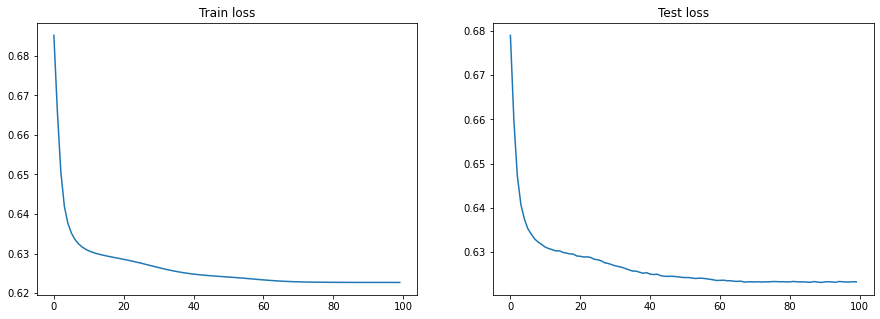

In [20]:
plot_history(history)

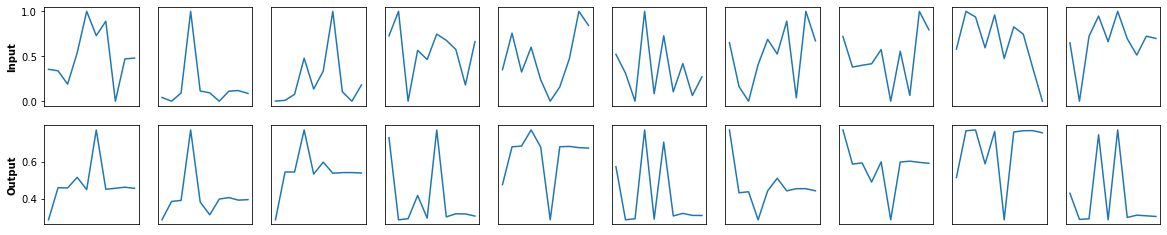

In [21]:
plot_examples(x_test_simple, decoded_stocks)

## Deep autoencoder + synthetic data

In [22]:
x_train_deep = np.concatenate((x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))),synthesized))
x_test_deep = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
input_window = Input(shape=(window_length,))

x = Dense(6, activation='relu')(input_window)
x = BatchNormalization()(x)
encoded = Dense(encoding_dim, activation='relu')(x)
x = Dense(6, activation='relu')(encoded)
x = BatchNormalization()(x)
decoded = Dense(window_length, activation='sigmoid')(x)
autoencoder = Model(input_window, decoded)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
history = autoencoder.fit(x_train_deep, x_train_deep,
                epochs=epochs,
                batch_size=1024,
                shuffle=True,
                validation_data=(x_test_deep, x_test_deep))

decoded_stocks = autoencoder.predict(x_test_deep)

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 66        
_________________________________________________________________
batch_normalization_2 (Batch (None, 6)                 24        
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 21        
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 24        
_________________________________________________________________
batch_normalization_3 (Batch (None, 6)                 24        
_________________________________________________________________
dense_11 (Dense)             (None, 10)                70 

Epoch 69/100
139/139 [==============================] - 1s 4ms/step - loss: 0.6235 - val_loss: 0.6237
Epoch 70/100
139/139 [==============================] - 1s 4ms/step - loss: 0.6236 - val_loss: 0.6236
Epoch 71/100
139/139 [==============================] - 1s 4ms/step - loss: 0.6235 - val_loss: 0.6239
Epoch 72/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6235 - val_loss: 0.6237
Epoch 73/100
139/139 [==============================] - 1s 4ms/step - loss: 0.6233 - val_loss: 0.6236
Epoch 74/100
139/139 [==============================] - 1s 4ms/step - loss: 0.6236 - val_loss: 0.6237
Epoch 75/100
139/139 [==============================] - 1s 4ms/step - loss: 0.6236 - val_loss: 0.6237
Epoch 76/100
139/139 [==============================] - 1s 4ms/step - loss: 0.6236 - val_loss: 0.6237
Epoch 77/100
139/139 [==============================] - 1s 4ms/step - loss: 0.6235 - val_loss: 0.6237
Epoch 78/100
139/139 [==============================] - 0s 3ms/step - loss: 0.6233

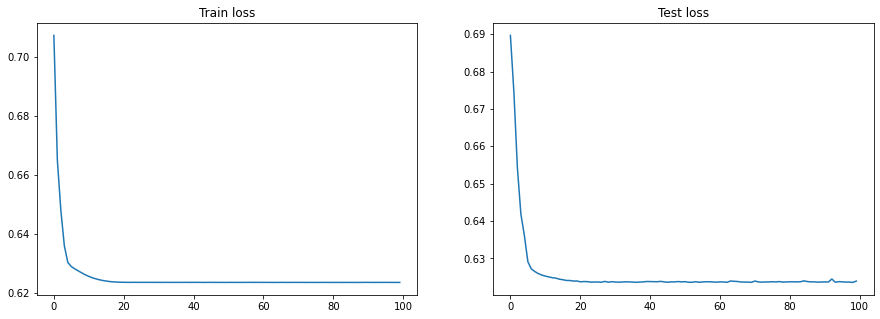

In [23]:
plot_history(history)

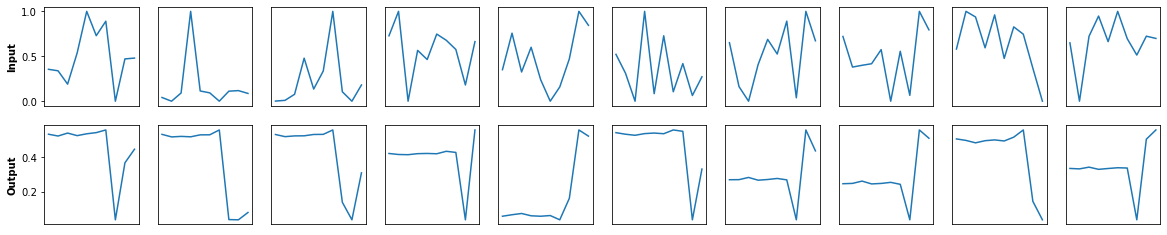

In [24]:
plot_examples(x_test_simple, decoded_stocks)